##### Main task
Ми хочемо зрозуміти, як користувачі з різних країн поводяться з часом:
– хто краще утримується \
– хто приносить більше цінності \
– де є проблеми продукту або локалізації 

Для цього треба:
> 1. Підготувати данні: очистка + створити InvoiceMonth
> 2. Визначити місяць входу користувача 
> 3. Обираємо топ країни
> 4. Рахуємо користувачів 
> 5. Рахуємо retention 
> 6. Будуємо heatmap

Final result: порівняти retention/churn між топ 3 країни. Зробити гіпотези варіанти виправлення та як перевірити що стало краще ( метрика )

In [19]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_excel('Online Retail.xlsx') # !! треба змінити на свій шлях !!

In [ ]:
# Data Cleaning 
df.drop_duplicates(inplace=True)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0) & (df['CustomerID'].notnull())]

In [ ]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"]) 
# pd.to_datetime() конвертує значення в тип datetime64[ns] Дозволяє: сортувати за датою, витягувати рік / місяць / день. аналізувати тренди й сезонність, Автоматично розпізнає більшість форматів дат

df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M").dt.to_timestamp()
# Create InvoiceMonth column
# dt.to_period("M") → перетворює дату на місячний період (Period[M]), наприклад: 2023-07-15 → 2023-07
# dt.to_timestamp() → перетворює період назад у datetime, перший день місяця: 2023-07 → 2023-07-01 00:00:00


In [ ]:
# Створити CohortMonth
df["CohortMonth"] = (
   df.groupby("CustomerID")["InvoiceDate"]
      .transform("min") # щоб отримати одного розміру мін по даті для кожного запису
      # Для кожного рядка повертає дату першої покупки відповідного клієнта transform, а не agg, щоб:зберегти той самий розмір DataFrame
      # мати значення в кожному рядку
      .dt.to_period("M").dt.to_timestamp()
)


In [8]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [10]:
# Формування час використання 
year_diff = df["InvoiceMonth"].dt.year - df["CohortMonth"].dt.year
month_diff = df["InvoiceMonth"].dt.month - df["CohortMonth"].dt.month

df["CohortIndex"] = year_diff * 12 + month_diff + 1
# Створює новий стовпець 'CohortIndex', який вказує на номер місяця когорти для кожного запису
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1


In [21]:
# Обираємо топ країни
top_countries = (
    df.groupby("Country")["CustomerID"]
      .nunique()                      # кількість унікальних клієнтів
      .sort_values(ascending=False)   # сортування за спаданням
      .head(5)                        # топ-5
      .index                          # беремо назви країн
)
df_geo = df[df["Country"].isin(top_countries)]
df_geo.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1


In [12]:
df_geo['Country'].value_counts()

Country
United Kingdom    349203
Germany             9025
France              8326
Spain               2479
Belgium             2031
Name: count, dtype: int64

In [31]:
# cohort_counts_geo = pd.pivot_table(       # створює зведену (pivot) таблицю для когортного аналізу по країнах.
#     df_geo,
#     index=["CohortMonth", "CohortIndex"],  # когорта + місяць
#     columns="Country",                     # країни
#     values="CustomerID",                   # клієнти
#     aggfunc="nunique"                      # кількість унікальних клієнтів
# )

cohort_counts_geo = pd.pivot_table( # щоб створити зведену таблицю
        df_geo,
        index=["Country", "CohortMonth"],
        columns='CohortIndex',
        values='CustomerID',
        aggfunc="nunique" # aggregation
)
cohort_counts_geo.head(10)

CohortIndex           1    2    3    4    5    6    7    8    9    10   11  \
Country CohortMonth                                                          
Belgium 2010-12-01   4.0  2.0  3.0  4.0  2.0  2.0  4.0  NaN  3.0  NaN  3.0   
        2011-01-01   1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
        2011-02-01   4.0  NaN  1.0  1.0  NaN  2.0  2.0  1.0  1.0  2.0  1.0   
        2011-03-01   4.0  1.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0  NaN  NaN   
        2011-04-01   2.0  1.0  1.0  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN   
        2011-05-01   2.0  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN   
        2011-06-01   4.0  NaN  1.0  3.0  1.0  3.0  NaN  NaN  NaN  NaN  NaN   
        2011-07-01   1.0  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN   
        2011-08-01   1.0  1.0  1.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN   
        2011-09-01   1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

CohortIndex           12   13  
Country CohortMonth            
Belgium 2010-12-01   1.0  2.0  
        2011-01-01   NaN  NaN  
        2011-02-01   NaN  NaN  
        2011-03-01   NaN  NaN  
        2011-04-01   NaN  NaN  
        2011-05-01   NaN  NaN  
        2011-06-01   NaN  NaN  
        2011-07-01   NaN  NaN  
        2011-08-01   NaN  NaN  
        2011-09-01   NaN  NaN

In [33]:
# Рахуємо retention    Retention = “збереження користувачів”
cohort_sizes_geo = cohort_counts_geo.iloc[:, 0]
cohort_sizes_geo
retention_geo = cohort_counts_geo.divide(cohort_sizes_geo, axis=0)


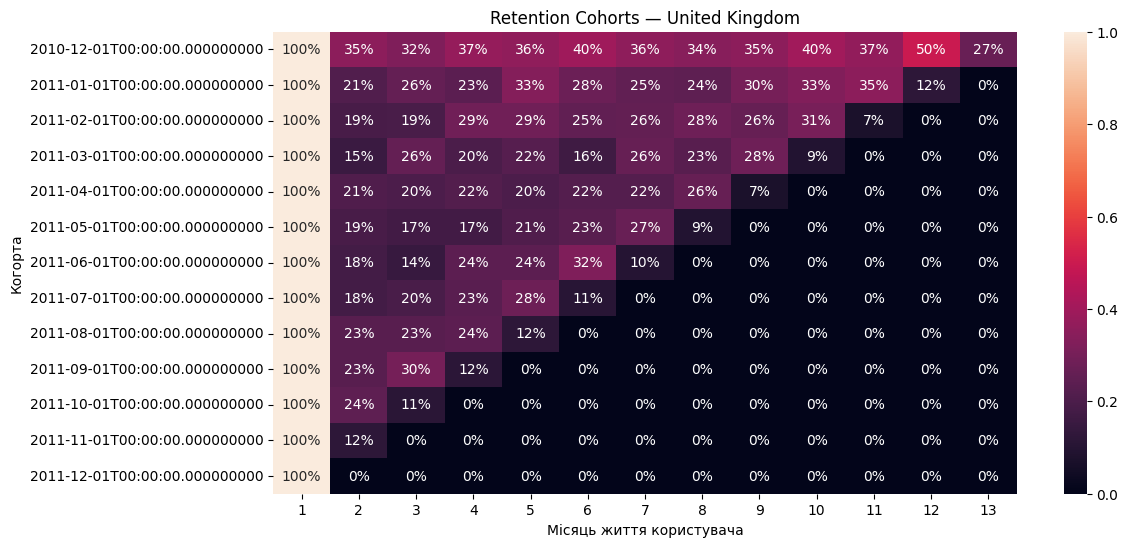

In [34]:
# Будуємо heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    retention_geo.loc["United Kingdom"],
    annot=True,
    fmt=".0%", 
    
)
plt.title("Retention Cohorts — United Kingdom")
plt.xlabel("Місяць життя користувача")
plt.ylabel("Когорта")
plt.show()

In [43]:
# Revenue/LTV
df_geo = df[df["Country"].isin(top_countries)].copy()
df_geo["Revenue"] = df_geo["Quantity"] * df_geo["UnitPrice"]
revenue_geo = pd.pivot_table(
    df_geo,
    index=["Country", "CohortMonth"],
    columns="CohortIndex",
    values= "Revenue",
    aggfunc="sum"
)
revenue_geo.head(10)

CohortIndex               1       2        3        4        5        6   \
Country CohortMonth                                                        
Belgium 2010-12-01   1809.91  974.60  1063.92  1440.92   397.52   665.61   
        2011-01-01    225.60     NaN      NaN      NaN      NaN      NaN   
        2011-02-01   1117.15     NaN   495.24   181.00      NaN   349.36   
        2011-03-01   1911.06  269.66   480.90   784.26   911.40   209.62   
        2011-04-01    827.06  297.38   337.84      NaN      NaN      NaN   
        2011-05-01   1107.51     NaN      NaN      NaN      NaN  1491.59   
        2011-06-01   2367.26     NaN   777.95  2106.11   450.86  2684.35   
        2011-07-01   1214.81     NaN      NaN      NaN  1195.09      NaN   
        2011-08-01    623.92   79.80   299.06      NaN   310.32      NaN   
        2011-09-01    549.84     NaN      NaN      NaN      NaN      NaN   

CohortIndex              7       8        9       10       11      12      13  
Country CohortMonth                                                            
Belgium 2010-12-01   785.46     NaN  1283.18     NaN  1142.21  772.38  578.37  
        2011-01-01      NaN     NaN      NaN     NaN      NaN     NaN     NaN  
        2011-02-01   659.35  829.99  1641.91  909.44   529.04     NaN     NaN  
        2011-03-01   642.28  300.76   754.50     NaN      NaN     NaN     NaN  
        2011-04-01   358.99     NaN      NaN     NaN      NaN     NaN     NaN  
        2011-05-01      NaN     NaN      NaN     NaN      NaN     NaN     NaN  
        2011-06-01      NaN     NaN      NaN     NaN      NaN     NaN     NaN  
        2011-07-01      NaN     NaN      NaN     NaN      NaN     NaN     NaN  
        2011-08-01      NaN     NaN      NaN     NaN      NaN     NaN     NaN  
        2011-09-01      NaN     NaN      NaN     NaN      NaN     NaN     NaN

In [45]:
# ARPU (Average Revenue Per User) для когортного аналізу по країнах.
arpu_geo = revenue_geo.divide(cohort_counts_geo, axis=0)
arpu_geo.head(10)

CohortIndex                 1       2       3           4        5   \
Country CohortMonth                                                   
Belgium 2010-12-01    452.4775  487.30  354.64  360.230000   198.76   
        2011-01-01    225.6000     NaN     NaN         NaN      NaN   
        2011-02-01    279.2875     NaN  495.24  181.000000      NaN   
        2011-03-01    477.7650  269.66  480.90  392.130000   911.40   
        2011-04-01    413.5300  297.38  337.84         NaN      NaN   
        2011-05-01    553.7550     NaN     NaN         NaN      NaN   
        2011-06-01    591.8150     NaN  777.95  702.036667   450.86   
        2011-07-01   1214.8100     NaN     NaN         NaN  1195.09   
        2011-08-01    623.9200   79.80  299.06         NaN   310.32   
        2011-09-01    549.8400     NaN     NaN         NaN      NaN   

CohortIndex                   6        7       8            9       10  \
Country CohortMonth                                                      
Belgium 2010-12-01    332.805000  196.365     NaN   427.726667     NaN   
        2011-01-01           NaN      NaN     NaN          NaN     NaN   
        2011-02-01    174.680000  329.675  829.99  1641.910000  454.72   
        2011-03-01    209.620000  642.280  300.76   754.500000     NaN   
        2011-04-01           NaN  358.990     NaN          NaN     NaN   
        2011-05-01   1491.590000      NaN     NaN          NaN     NaN   
        2011-06-01    894.783333      NaN     NaN          NaN     NaN   
        2011-07-01           NaN      NaN     NaN          NaN     NaN   
        2011-08-01           NaN      NaN     NaN          NaN     NaN   
        2011-09-01           NaN      NaN     NaN          NaN     NaN   

CohortIndex                  11      12       13  
Country CohortMonth                               
Belgium 2010-12-01   380.736667  772.38  289.185  
        2011-01-01          NaN     NaN      NaN  
        2011-02-01   529.040000     NaN      NaN  
        2011-03-01          NaN     NaN      NaN  
        2011-04-01          NaN     NaN      NaN  
        2011-05-01          NaN     NaN      NaN  
        2011-06-01          NaN     NaN      NaN  
        2011-07-01          NaN     NaN      NaN  
        2011-08-01          NaN     NaN      NaN  
        2011-09-01          NaN     NaN      NaN

In [46]:
# LTV (Lifetime Value, “пожиттєва цінність клієнта”) — це середній дохід від одного користувача за весь час його взаємодії з продуктом.
# У когортному аналізі LTV часто розраховують на основі ARPU і накопичуваного доходу по місяцях життя когорт.
ltv_geo = arpu_geo.cumsum(axis=1)
ltv_geo.head(10)

CohortIndex                 1         2          3            4            5   \
Country CohortMonth                                                             
Belgium 2010-12-01    452.4775  939.7775  1294.4175  1654.647500  1853.407500   
        2011-01-01    225.6000       NaN        NaN          NaN          NaN   
        2011-02-01    279.2875       NaN   774.5275   955.527500          NaN   
        2011-03-01    477.7650  747.4250  1228.3250  1620.455000  2531.855000   
        2011-04-01    413.5300  710.9100  1048.7500          NaN          NaN   
        2011-05-01    553.7550       NaN        NaN          NaN          NaN   
        2011-06-01    591.8150       NaN  1369.7650  2071.801667  2522.661667   
        2011-07-01   1214.8100       NaN        NaN          NaN  2409.900000   
        2011-08-01    623.9200  703.7200  1002.7800          NaN  1313.100000   
        2011-09-01    549.8400       NaN        NaN          NaN          NaN   

CohortIndex                 6          7          8            9          10  \
Country CohortMonth                                                            
Belgium 2010-12-01   2186.2125  2382.5775        NaN  2810.304167        NaN   
        2011-01-01         NaN        NaN        NaN          NaN        NaN   
        2011-02-01   1130.2075  1459.8825  2289.8725  3931.782500  4386.5025   
        2011-03-01   2741.4750  3383.7550  3684.5150  4439.015000        NaN   
        2011-04-01         NaN  1407.7400        NaN          NaN        NaN   
        2011-05-01   2045.3450        NaN        NaN          NaN        NaN   
        2011-06-01   3417.4450        NaN        NaN          NaN        NaN   
        2011-07-01         NaN        NaN        NaN          NaN        NaN   
        2011-08-01         NaN        NaN        NaN          NaN        NaN   
        2011-09-01         NaN        NaN        NaN          NaN        NaN   

CohortIndex                   11           12           13  
Country CohortMonth                                         
Belgium 2010-12-01   3191.040833  3963.420833  4252.605833  
        2011-01-01           NaN          NaN          NaN  
        2011-02-01   4915.542500          NaN          NaN  
        2011-03-01           NaN          NaN          NaN  
        2011-04-01           NaN          NaN          NaN  
        2011-05-01           NaN          NaN          NaN  
        2011-06-01           NaN          NaN          NaN  
        2011-07-01           NaN          NaN          NaN  
        2011-08-01           NaN          NaN          NaN  
        2011-09-01           NaN          NaN          NaN